In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import os

# weight and biases
import wandb
#from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# from other scripts
from DeepPhys_dataloader import TensorDataset
from DeepPhys_model import DeepPhys
from DeepPhys_training import train_model
from DeepPhys_training import plot_loss_curves
from DeepPhys_testing import test_model
from DeepPhys_training import setup_training
from DeepPhys_training import EarlyStopping
from DeepPhys_training import NegativePearsonCorrelation
from DeepPhys_gradcam import GradCAM
from DeepPhys_gradcam import visualize_gradcam
from DeepPhys_gradcam import visualize_gradcam_batch


In [2]:

# initiliaze model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DeepPhys( img_size=36)
model = model.to(device)

# log in in weight and biases 
config = wandb.config
wandb.init(project="DeepPhys_Paper_Norm",entity="aml-final-project", config=config, settings=wandb.Settings(init_timeout=300))


wandb: Currently logged in as: eledelgo (aml-final-project). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
# Hyperparameters
batch_size = 32
num_epochs = 50

## create dataloaders

In [4]:
# Create DataLoaders
train_dir = "/work/AML_Project/6_DeepPhys_Paper/Dataset/Train"
val_dir = "/work/AML_Project/6_DeepPhys_Paper/Dataset/Validation"
test_dir = "/work/AML_Project/6_DeepPhys_Paper/Dataset/Test"



In [5]:
# check task is loader 

# Create dataloaders with augmentation
train_loader, val_loader, test_loader = TensorDataset.create_dataloaders(
    train_dir=train_dir,
    val_dir=val_dir,
    test_dir=test_dir,
    batch_size=batch_size,
    tasks="all",  
    augment=False  # no augmentation
)

for batch_idx, (inputs, labels) in enumerate(train_loader):
    print ("\nTraining Set")
    print(f"Input Shape: {inputs.shape}")  # [batch_size, 6, 72, 72]
    print(f"Label Shape: {labels.shape}")  # [batch_size, 1]
    break

for batch_idx, (inputs, labels) in enumerate(val_loader):
    print ("\nValidation Set")
    print(f"Input Shape: {inputs.shape}")  # [batch_size, 6, 72, 72]
    print(f"Label Shape: {labels.shape}")  # [batch_size, 1]
    break

for batch_idx, (inputs, labels) in enumerate(test_loader):
    print ("\nTest Set")
    print(f"Input Shape: {inputs.shape}")  # [batch_size, 6, 72, 72]
    print(f"Label Shape: {labels.shape}")  # [batch_size, 1]
    break


Training Set
Input Shape: torch.Size([32, 6, 36, 36])
Label Shape: torch.Size([32, 1])

Validation Set
Input Shape: torch.Size([32, 6, 36, 36])
Label Shape: torch.Size([32, 1])

Test Set
Input Shape: torch.Size([32, 6, 36, 36])
Label Shape: torch.Size([32, 1])


In [6]:
# Check the size of the dataset (number of samples) before and after augmentation
print(f"Training Loader - samples : {len(train_loader.dataset)}\n")
print(f"Number of validation samples: {len(val_loader.dataset)}\n")
print(f"Number of test samples: {len(test_loader.dataset)}\n")


Training Loader - samples : 75074

Number of validation samples: 21450

Number of test samples: 23595



In [7]:
def check_data(dataloader):
    """Check data statistics"""
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        print(f"\nBatch {batch_idx} statistics:")
        print(f"Input shape: {inputs.shape}")
        print(f"Target shape: {targets.shape}")
        print(f"Input range: [{inputs.min():.4f}, {inputs.max():.4f}]")
        print(f"Target range: [{targets.min():.4f}, {targets.max():.4f}]")
        print(f"Input mean: {inputs.mean():.4f}")
        print(f"Target mean: {targets.mean():.4f}")
        print(f"Input std: {inputs.std():.4f}")
        print(f"Target std: {targets.std():.4f}")
        if batch_idx == 2:  # Check first 3 batches
            break

# Use it before training
check_data(train_loader)


Batch 0 statistics:
Input shape: torch.Size([32, 6, 36, 36])
Target shape: torch.Size([32, 1])
Input range: [-37.1300, 18.1724]
Target range: [0.0676, 0.9460]
Input mean: -0.0008
Target mean: 0.4984
Input std: 1.0001
Target std: 0.2609

Batch 1 statistics:
Input shape: torch.Size([32, 6, 36, 36])
Target shape: torch.Size([32, 1])
Input range: [-50.7230, 61.0370]
Target range: [0.0077, 0.8896]
Input mean: 0.0010
Target mean: 0.5038
Input std: 1.0001
Target std: 0.2332

Batch 2 statistics:
Input shape: torch.Size([32, 6, 36, 36])
Target shape: torch.Size([32, 1])
Input range: [-28.7960, 28.7960]
Target range: [0.0184, 0.8919]
Input mean: 0.0032
Target mean: 0.4805
Input std: 1.0000
Target std: 0.2629


## Training

In [8]:
criterion, optimizer, scheduler, early_stopping = setup_training(model)
# NPC loss 
# lr starts at 0.0001
# weight decay = 0.0001

/home/ucloud/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=num_epochs,
    device='cuda',  # Or 'cpu' if you don't have a GPU
    early_stopping=early_stopping
)



Epoch 1/50


Validation: 100%|██████████| 671/671 [00:28<00:00, 23.36it/s]


Epoch 1/50
Training Loss: -0.3385
Validation Loss: 0.0416
Learning Rate: 0.000100
Epoch 2/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 70.53it/s]


Epoch 2/50
Training Loss: -0.5559
Validation Loss: 0.0154
Learning Rate: 0.000100
Epoch 3/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 69.38it/s]


Epoch 3/50
Training Loss: -0.6273
Validation Loss: 0.0236
Learning Rate: 0.000100
Epoch 4/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 61.13it/s]


Epoch 4/50
Training Loss: -0.6675
Validation Loss: 0.0367
Learning Rate: 0.000100
Epoch 5/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 65.63it/s]


Epoch 5/50
Training Loss: -0.6951
Validation Loss: 0.0641
Learning Rate: 0.000100
Epoch 6/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 71.89it/s]


Epoch 6/50
Training Loss: -0.7161
Validation Loss: 0.0416
Learning Rate: 0.000100
Epoch 7/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 67.71it/s]


Epoch 7/50
Training Loss: -0.7346
Validation Loss: 0.0098
Learning Rate: 0.000100
Epoch 8/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 61.59it/s]


Epoch 8/50
Training Loss: -0.7488
Validation Loss: 0.0130
Learning Rate: 0.000100
Epoch 9/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 70.41it/s]


Epoch 9/50
Training Loss: -0.7611
Validation Loss: 0.0091
Learning Rate: 0.000100
Epoch 10/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 73.24it/s]


Epoch 10/50
Training Loss: -0.7701
Validation Loss: 0.0176
Learning Rate: 0.000100
Epoch 11/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 72.59it/s]


Epoch 11/50
Training Loss: -0.7793
Validation Loss: 0.0170
Learning Rate: 0.000100
Epoch 12/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 71.19it/s]


Epoch 12/50
Training Loss: -0.7903
Validation Loss: 0.0040
Learning Rate: 0.000100
Epoch 13/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 68.07it/s]


Epoch 13/50
Training Loss: -0.7968
Validation Loss: 0.0212
Learning Rate: 0.000100
Epoch 14/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 70.85it/s]


Epoch 14/50
Training Loss: -0.8035
Validation Loss: 0.0200
Learning Rate: 0.000100
Epoch 15/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 65.46it/s]


Epoch 15/50
Training Loss: -0.8080
Validation Loss: 0.0142
Learning Rate: 0.000100
Epoch 16/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 71.26it/s]


Epoch 16/50
Training Loss: -0.8125
Validation Loss: -0.0409
Learning Rate: 0.000100
Epoch 17/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 71.44it/s]


Epoch 17/50
Training Loss: -0.8188
Validation Loss: -0.0231
Learning Rate: 0.000100
Epoch 18/50


Validation: 100%|██████████| 671/671 [00:13<00:00, 48.44it/s]


Epoch 18/50
Training Loss: -0.8229
Validation Loss: -0.0320
Learning Rate: 0.000100
Epoch 19/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 67.30it/s]


Epoch 19/50
Training Loss: -0.8262
Validation Loss: -0.0048
Learning Rate: 0.000100
Epoch 20/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 69.64it/s]


Epoch 20/50
Training Loss: -0.8310
Validation Loss: -0.0463
Learning Rate: 0.000100
Epoch 21/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 67.38it/s]


Epoch 21/50
Training Loss: -0.8338
Validation Loss: -0.0712
Learning Rate: 0.000100
Epoch 22/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 70.34it/s]


Epoch 22/50
Training Loss: -0.8376
Validation Loss: -0.0537
Learning Rate: 0.000100
Epoch 23/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 70.71it/s]


Epoch 23/50
Training Loss: -0.8402
Validation Loss: -0.0208
Learning Rate: 0.000100
Epoch 24/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 65.83it/s]


Epoch 24/50
Training Loss: -0.8425
Validation Loss: -0.0436
Learning Rate: 0.000100
Epoch 25/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 65.34it/s]


Epoch 25/50
Training Loss: -0.8455
Validation Loss: -0.0007
Learning Rate: 0.000100
Epoch 26/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 73.16it/s]


Epoch 26/50
Training Loss: -0.8466
Validation Loss: 0.0028
Learning Rate: 0.000100
Epoch 27/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 72.21it/s]


Epoch 27/50
Training Loss: -0.8517
Validation Loss: 0.0286
Learning Rate: 0.000010
Epoch 28/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 67.16it/s]


Epoch 28/50
Training Loss: -0.8597
Validation Loss: 0.0166
Learning Rate: 0.000010
Epoch 29/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 65.25it/s]


Epoch 29/50
Training Loss: -0.8625
Validation Loss: 0.0074
Learning Rate: 0.000010
Epoch 30/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 65.80it/s]


Epoch 30/50
Training Loss: -0.8645
Validation Loss: 0.0085
Learning Rate: 0.000010
Epoch 31/50


Validation: 100%|██████████| 671/671 [00:10<00:00, 66.97it/s]


Epoch 31/50
Training Loss: -0.8639
Validation Loss: 0.0114
Learning Rate: 0.000010
Epoch 32/50


Validation: 100%|██████████| 671/671 [00:08<00:00, 74.82it/s]


Epoch 32/50
Training Loss: -0.8646
Validation Loss: 0.0135
Learning Rate: 0.000010
Epoch 33/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 69.73it/s]


Epoch 33/50
Training Loss: -0.8652
Validation Loss: 0.0099
Learning Rate: 0.000001
Epoch 34/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 72.98it/s]


Epoch 34/50
Training Loss: -0.8676
Validation Loss: 0.0093
Learning Rate: 0.000001
Epoch 35/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 68.52it/s]


Epoch 35/50
Training Loss: -0.8665
Validation Loss: 0.0089
Learning Rate: 0.000001
Epoch 36/50


Validation: 100%|██████████| 671/671 [00:09<00:00, 67.91it/s]


Epoch 36/50
Training Loss: -0.8672
Validation Loss: 0.0087
Learning Rate: 0.000001
Early stopping triggered


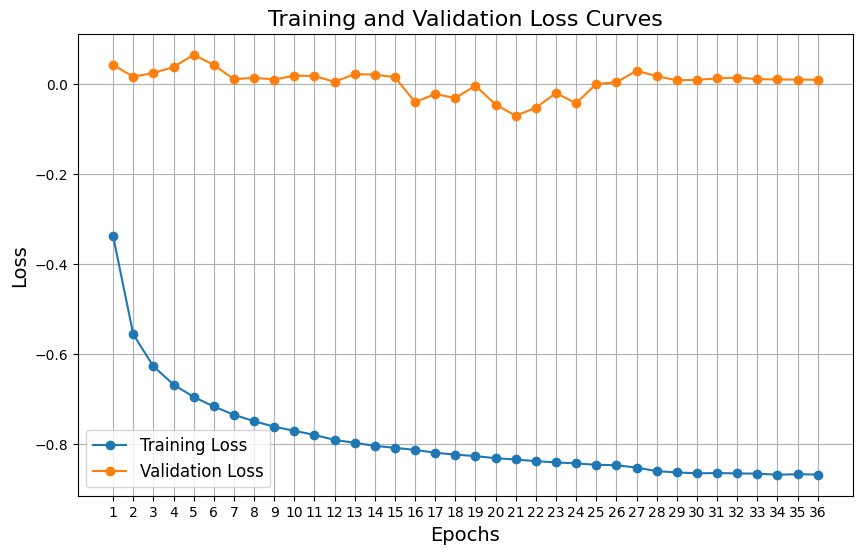

In [10]:
plot_loss_curves(train_losses, val_losses)

## testing

In [11]:
avg_test_loss, all_preds, all_labels = test_model(model, test_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu')


Testing: 100%|██████████| 738/738 [00:27<00:00, 27.23batch/s]


Test Loss: -0.0419


In [12]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
learning_rate,██████████████████████████▂▂▂▂▂▂▁▁▁▁
test loss,▁
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅▆▇█▇▅▅▅▆▆▅▆▆▅▃▃▃▄▂▁▂▄▂▅▅▆▆▅▅▅▅▅▅▅▅
best_val_loss,-0.07124
early_stopped,True
epoch,36
final_train_loss,-0.86715
final_val_loss,0.00868
learning_rate,0.0


/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


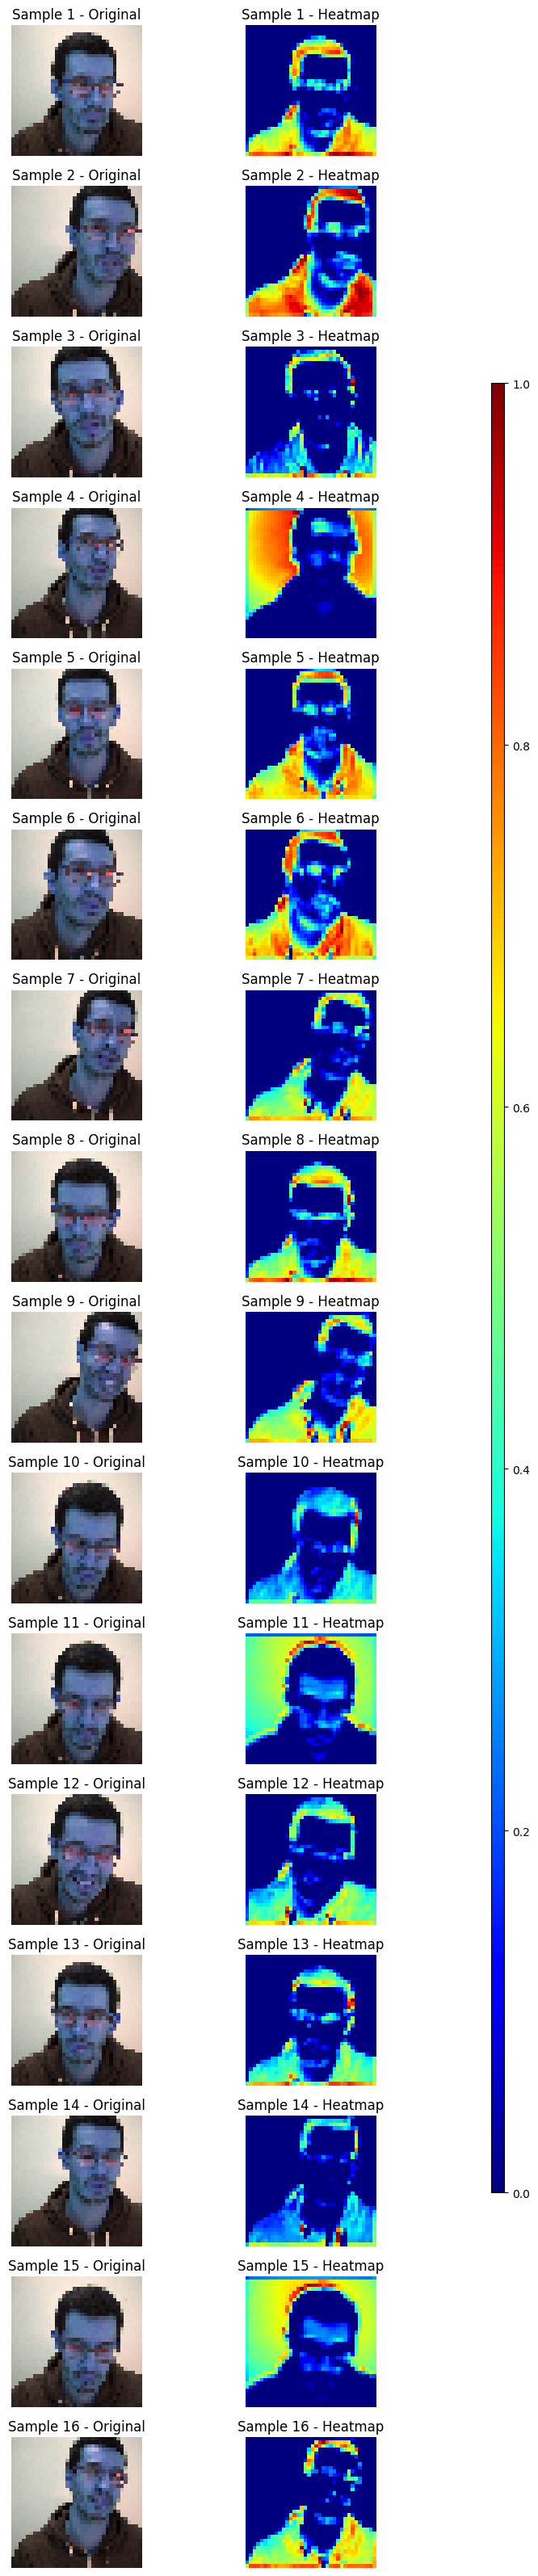

In [13]:
target_layer = model.apperance_conv1
visualize_gradcam_batch(model, val_loader, target_layer, device)


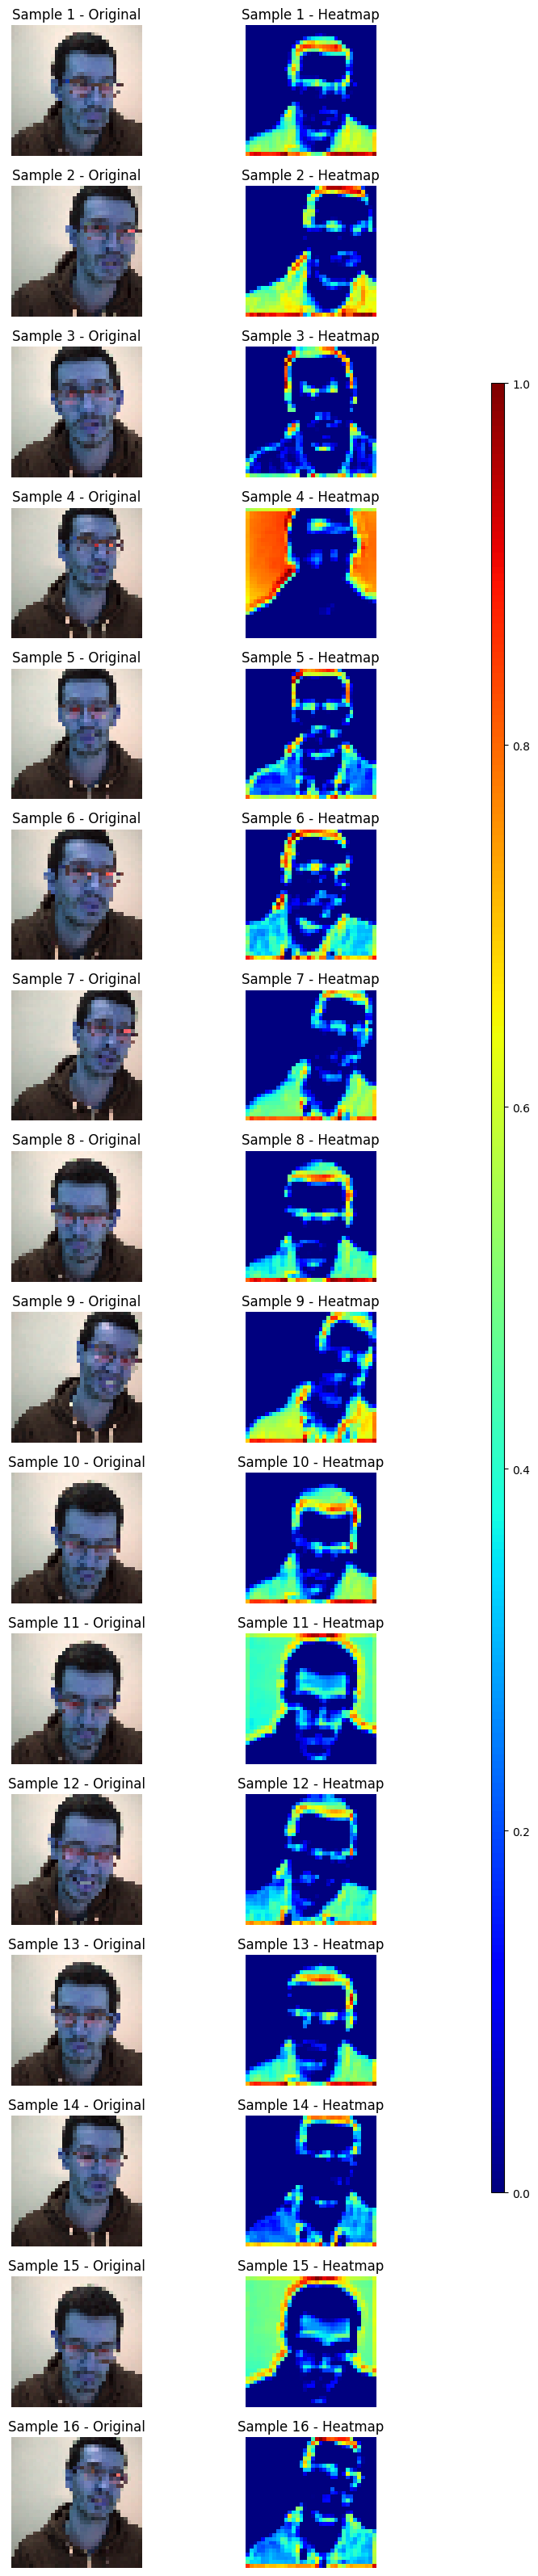

In [14]:
target_layer = model.apperance_conv2
visualize_gradcam_batch(model, val_loader, target_layer, device)


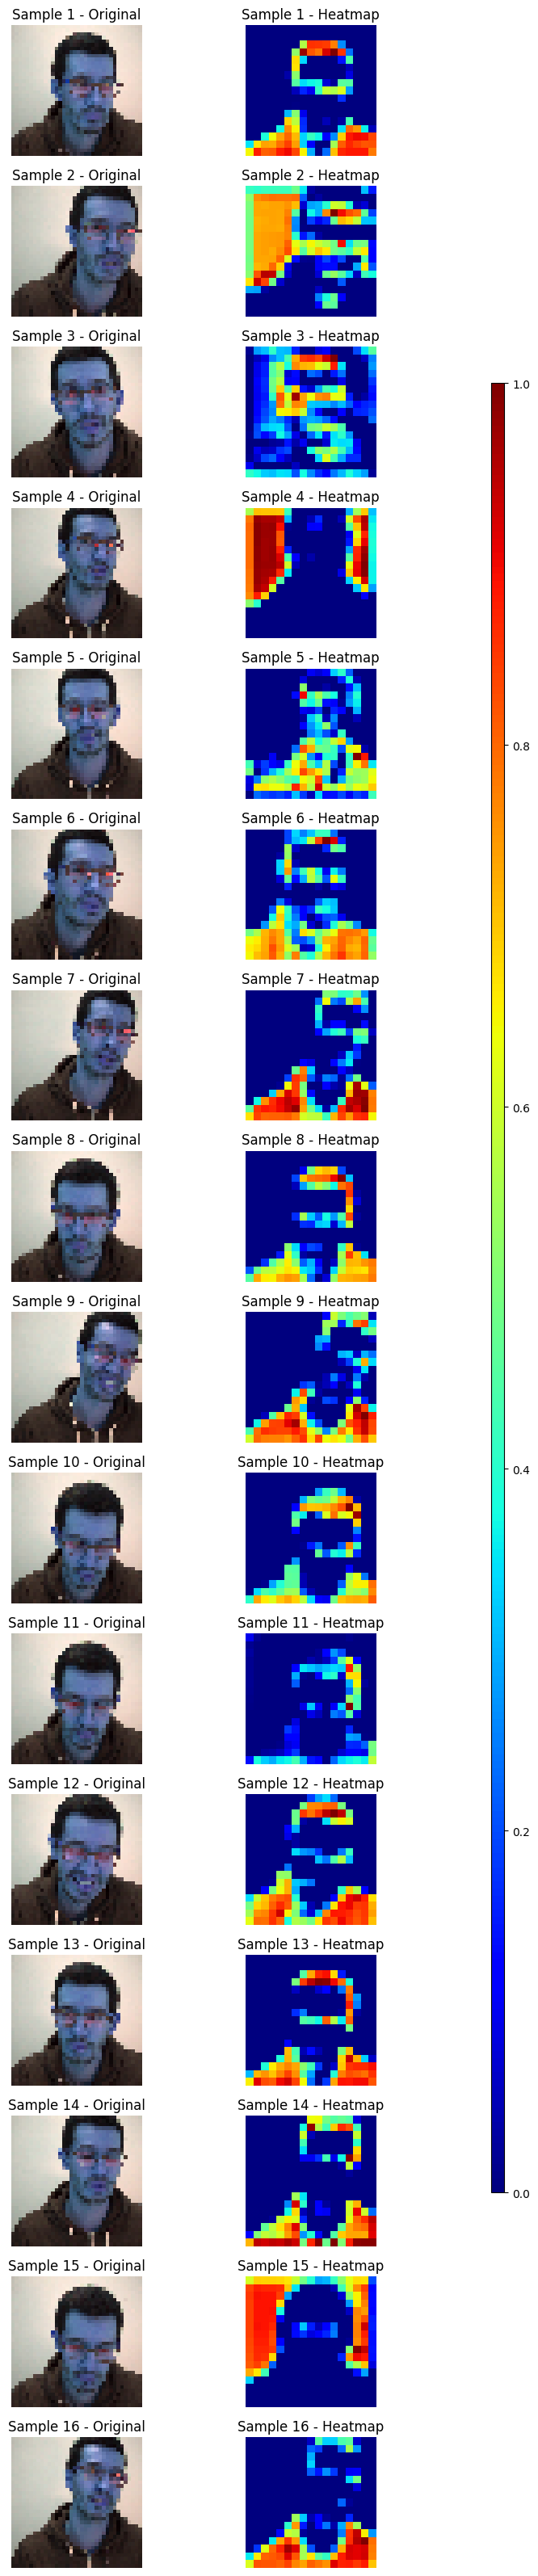

In [15]:
target_layer = model.apperance_conv3
visualize_gradcam_batch(model, val_loader, target_layer, device)


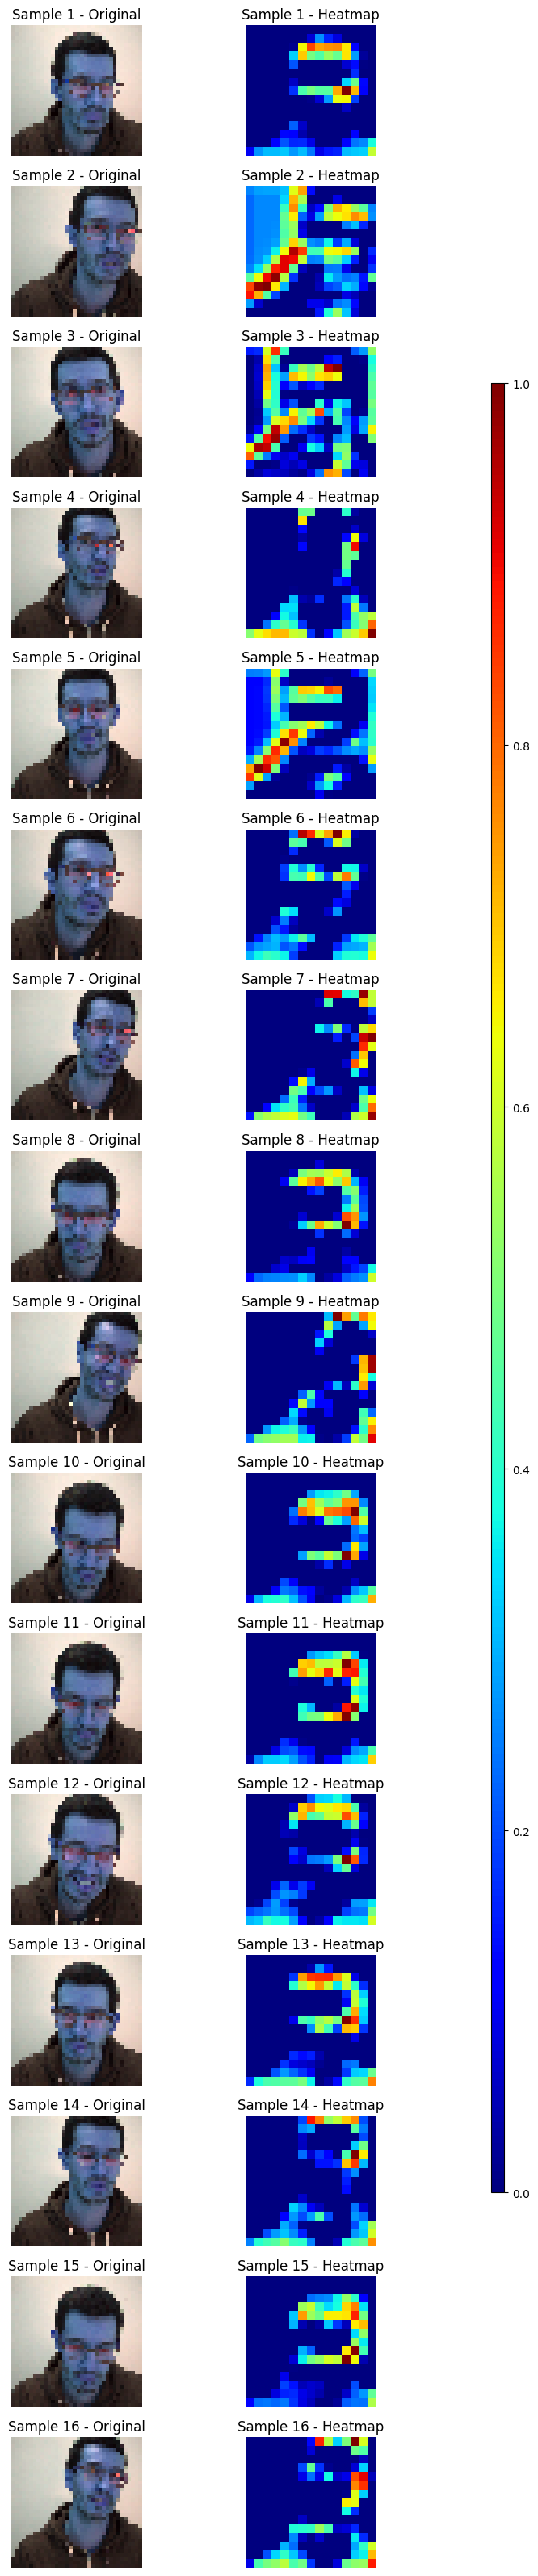

In [16]:
target_layer = model.apperance_conv4
visualize_gradcam_batch(model, val_loader, target_layer, device)
